# Plaque-Mitochondria Spatial Analysis

This notebook performs spatial correlation analysis between amyloid plaques and mitochondrial calcium events in 3D brain tissue imaging data.

## Analysis Overview
1. **Plaque Segmentation**: 3D segmentation and filtering of amyloid plaques
2. **Mitochondrial Event Processing**: Extraction of ROI centroids and calcium event classification
3. **Spatial Analysis**: Distance calculations between plaques and mitochondrial events
4. **Visualization**: 3D visualization of spatial relationships
5. **Statistical Analysis**: Distance-based classification and distribution analysis

In [8]:
# Import required libraries
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import os
import scipy.io
import h5py
from scipy.io import savemat

# Set file paths
input_plaque_tif = './plaque.tif'  # 3D plaque channel TIFF file
mito_input_dir = './mito_events'   # Directory containing mitochondrial events data

print("Libraries imported successfully")
print(f"Plaque file: {input_plaque_tif}")
print(f"Mito events directory: {mito_input_dir}")

Libraries imported successfully
Plaque file: ./plaque.tif
Mito events directory: ./mito_events


## 1. Plaque Segmentation and Analysis

This section performs 3D segmentation of amyloid plaques from the TIFF image stack, applies morphological operations to improve segmentation quality, and extracts centroid coordinates and volumes for each plaque.

In [9]:
# Load 3D plaque TIFF data
print("Loading plaque TIFF data...")
with tf.TiffFile(input_plaque_tif) as tif:
    images = tif.asarray()

print(f"Image shape: {images.shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")

# Apply Otsu thresholding for initial segmentation
print("\nApplying Otsu thresholding...")
thresh = threshold_otsu(images)
binary_images = images > thresh
print(f"Threshold value: {thresh}")
print(f"Binary image sum: {np.sum(binary_images)} voxels")

# Apply 3D morphological closing to improve segmentation
# Use spherical structuring element for 3D operations
print("\nApplying morphological closing...")
binary_images_closed = binary_closing(binary_images, ball(5))
print(f"After closing - sum: {np.sum(binary_images_closed)} voxels")

# Label connected components in 3D
print("\nLabeling connected components...")
labeled_images, num_features = label(binary_images_closed, connectivity=3, return_num=True)
props = regionprops(labeled_images)

print(f"Identified 3D objects: {num_features}")

# Extract information for all plaques
print("\nExtracting plaque information...")
all_blobs_info = []

for i, prop in enumerate(props):
    # Get centroid coordinates and volume (area in 3D represents volume)
    centroid_3D = prop.centroid  # Returns (z, y, x) format
    volume = prop.area  # In 3D, area represents volume in voxels
    
    blob_info = {
        "id": i + 1,
        "3D_centroid_z": centroid_3D[0],
        "3D_centroid_y": centroid_3D[1],
        "3D_centroid_x": centroid_3D[2],
        "volume": volume
    }
    all_blobs_info.append(blob_info)

# Display all plaque information
print("\nAll identified plaques:")
for blob in all_blobs_info:
    print(f"Plaque {blob['id']}: Centroid (Z, Y, X) = ({blob['3D_centroid_z']:.1f}, {blob['3D_centroid_y']:.1f}, {blob['3D_centroid_x']:.1f}), Volume = {blob['volume']} voxels")

# Filter plaques by volume threshold (remove small artifacts)
volume_threshold = 50
filtered_props = [prop for prop in props if prop.area >= volume_threshold]
filtered_blobs_info = [{
    "id": i + 1,
    "3D_centroid_z": prop.centroid[0],
    "3D_centroid_y": prop.centroid[1],
    "3D_centroid_x": prop.centroid[2],
    "volume": prop.area
} for i, prop in enumerate(filtered_props)]

print(f"\nAfter filtering (volume >= {volume_threshold}):")
print(f"Filtered plaques: {len(filtered_blobs_info)}")
for blob in filtered_blobs_info:
    print(f"Plaque {blob['id']}: Centroid (Z, Y, X) = ({blob['3D_centroid_z']:.1f}, {blob['3D_centroid_y']:.1f}, {blob['3D_centroid_x']:.1f}), Volume = {blob['volume']} voxels")

Loading plaque TIFF data...
Image shape: (141, 440, 512)
Data type: uint16
Value range: [7863, 9711]

Applying Otsu thresholding...
Threshold value: 8171
Binary image sum: 17421 voxels

Applying morphological closing...
After closing - sum: 20515 voxels

Labeling connected components...
Identified 3D objects: 7

Extracting plaque information...

All identified plaques:
Plaque 1: Centroid (Z, Y, X) = (1.2, 126.6, 389.2), Volume = 5.0 voxels
Plaque 2: Centroid (Z, Y, X) = (0.4, 249.1, 322.0), Volume = 10.0 voxels
Plaque 3: Centroid (Z, Y, X) = (0.2, 358.5, 76.5), Volume = 4.0 voxels
Plaque 4: Centroid (Z, Y, X) = (0.8, 382.9, 228.6), Volume = 36.0 voxels
Plaque 5: Centroid (Z, Y, X) = (5.0, 3.0, 276.0), Volume = 1.0 voxels
Plaque 6: Centroid (Z, Y, X) = (21.6, 190.5, 120.7), Volume = 4554.0 voxels
Plaque 7: Centroid (Z, Y, X) = (31.3, 215.1, 376.4), Volume = 15905.0 voxels

After filtering (volume >= 50):
Filtered plaques: 2
Plaque 1: Centroid (Z, Y, X) = (21.6, 190.5, 120.7), Volume = 4

## 2. Mitochondrial Event Processing

This section extracts mitochondrial ROI centroids and identifies calcium events.

In [11]:
def get_data_from_reference(ref, file, field):
    """Helper function to extract data from reference object in MAT file"""
    ref_data = file[ref]
    # Squeeze to remove single-dimensional entries
    data = np.array(ref_data[field]).squeeze()
    return data

print("Loading mitochondrial event data...")

# Load mitochondrial statistics
with h5py.File(f'{mito_input_dir}/mito_stat.mat', 'r') as file:
    mito_stat = file['mito_stat']
    refs = file['#refs#']

    # Initialize arrays for storing centroids and points
    mito_centroids = []
    mito_points_x, mito_points_y = [], []

    print("\nExtracting all mitochondrial ROI centroids...")
    # Extract centroids for all mitochondrial events
    for idx in range(mito_stat.shape[0]):
        # Extract pixel coordinates from structure
        struct_ref = mito_stat[idx, 0]
        x_coords = get_data_from_reference(struct_ref, refs, 'xpix')
        y_coords = get_data_from_reference(struct_ref, refs, 'ypix')
        
        # Store all pixel points
        mito_points_x.extend(list(x_coords))
        mito_points_y.extend(list(y_coords))

        # Calculate ROI centroid
        mito_centroid_x_2d = np.mean(x_coords)
        mito_centroid_y_2d = np.mean(y_coords)
        mito_centroids.append([mito_centroid_x_2d, mito_centroid_y_2d])

    mito_centroids = np.array(mito_centroids)
    print(f"Extracted {len(mito_centroids)} mitochondrial centroids")

    # Extract centroids for calcium events
    print("\nExtracting calcium event centroids...")
    mat_data = scipy.io.loadmat(f'{mito_input_dir}/Label.mat')
    has_calcase = mat_data['predicted_label'].flatten()
    
    calcium_indices = np.where(has_calcase == 2)[0]
    print(f"Calcium event indices: {calcium_indices}")

    calcase_centroids = []
    for idx in calcium_indices:
        struct_ref = mito_stat[idx, 0]
        calcase_x_coords = get_data_from_reference(struct_ref, refs, 'xpix')
        calcase_y_coords = get_data_from_reference(struct_ref, refs, 'ypix')

        # Calculate centroid
        calcase_centroids_x_2d = np.mean(calcase_x_coords)
        calcase_centroids_y_2d = np.mean(calcase_y_coords)
        calcase_centroids.append([calcase_centroids_x_2d, calcase_centroids_y_2d])

    calcase_centroids = np.array(calcase_centroids)
    print(f"Extracted {len(calcase_centroids)} calcium event centroids")

    # Save processed centroids to MAT file
    print("\nSaving processed centroids...")
    savemat(f'{mito_input_dir}/calcase_centroids.mat', {'calcase_centroids': calcase_centroids})
    print("Centroids saved successfully")

Loading mitochondrial event data...

Extracting all mitochondrial ROI centroids...
Extracted 2521 mitochondrial centroids

Extracting calcium event centroids...
Calcium event indices: [   0    1    2    3    4    6    9   10   12   13   36   37   40   44
   45   50   52   82   95  116  138  233  236  261  333  479  685  789
  844 1498 1729]
Extracted 31 calcium event centroids

Saving processed centroids...
Centroids saved successfully


## 3. 3D Spatial Visualization

This section creates 3D scatter plots to visualize the spatial relationships between plaques and calcium events.

Creating 3D spatial visualization...


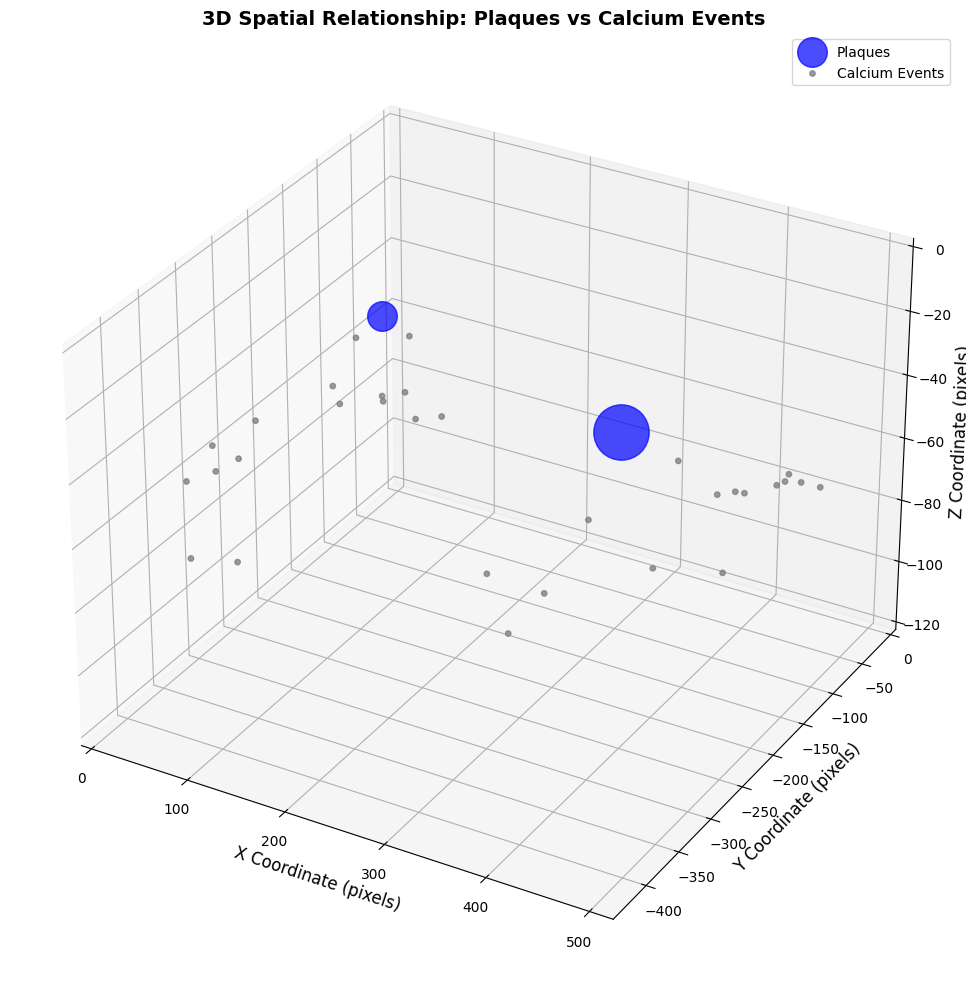

3D visualization completed


In [12]:
# Create 3D visualization of spatial relationships
print("Creating 3D spatial visualization...")

# Create 3D figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D plaque locations
# Use sphere size proportional to volume for better visualization
for blob in filtered_blobs_info:
    # Scale sphere size by volume (divide by 10 for reasonable visualization)
    sphere_size = blob['volume'] / 10
    ax.scatter(blob['3D_centroid_x'], 
              -blob['3D_centroid_y'], 
              -blob['3D_centroid_z'], 
              color='blue', 
              s=sphere_size, 
              alpha=0.7,
              label='Plaques' if blob['id'] == 1 else "")

# Plot calcium events (grey points)
if len(calcase_centroids) > 0:
    # Use Z-axis position from file or default value
    try:
        with open(f'{mito_input_dir}/Z-axis.txt', 'r') as f:
            z_position = int(f.read().strip())
    except:
        z_position = 57  # Default Z position
    
    ax.scatter(calcase_centroids[:, 0], 
              -calcase_centroids[:, 1], 
              -z_position, 
              color='grey', 
              s=15, 
              alpha=0.8,
              label='Calcium Events')

# Configure plot appearance
ax.set_xlabel('X Coordinate (pixels)', fontsize=12)
ax.set_ylabel('Y Coordinate (pixels)', fontsize=12)
ax.set_zlabel('Z Coordinate (pixels)', fontsize=12)
ax.set_title('3D Spatial Relationship: Plaques vs Calcium Events', fontsize=14, fontweight='bold')

# Invert Y and Z axes to match image coordinate system
ax.invert_yaxis()
ax.invert_zaxis()

# Set axis limits for better visualization
ax.set_xlim([0, 512])
ax.set_ylim([-440, 0])
ax.set_zlim([-120, 0])

# Add legend
ax.legend()

# Add grid for better spatial reference
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("3D visualization completed")

## 4. Distance Analysis and Spatial Classification

This section calculates the nearest plaque distances for each mitochondrial event and classifies them based on distance to plaques.

In [13]:
def load_z_axis(filepath):
    """Load Z-axis position from text file"""
    with open(filepath, 'r') as file:
        return int(file.read().strip())

def calculate_nearest_3d_distance(centroids_2d, z_axis, blobs_3d_info):
    """Calculate nearest plaque distance for each event"""
    distances = []
    
    for idx, (x, y) in enumerate(centroids_2d):
        min_distance = np.inf
        
        # Calculate distance to each plaque
        for blob in blobs_3d_info:
            distance = np.sqrt((blob['3D_centroid_x'] - x)**2 + 
                              (blob['3D_centroid_y'] - y)**2 + 
                              (blob['3D_centroid_z'] - z_axis)**2)
            
            if distance < min_distance:
                min_distance = distance
        
        distances.append(min_distance)
    
    return distances

print("Performing distance analysis...")

# Load Z-axis position
try:
    z_axis = load_z_axis(os.path.join(mito_input_dir, 'Z-axis.txt'))
    print(f"Z-axis position: {z_axis}")
except:
    z_axis = 57  # Default Z position
    print(f"Using default Z-axis position: {z_axis}")

# Calculate distances for all mitochondrial events
print(f"\nCalculating distances for {len(mito_centroids)} mitochondrial events...")
all_distances = calculate_nearest_3d_distance(mito_centroids, z_axis, filtered_blobs_info)

# Calculate distances for calcium events
print(f"Calculating distances for {len(calcase_centroids)} calcium events...")
calcium_distances = calculate_nearest_3d_distance(calcase_centroids, z_axis, filtered_blobs_info)

# Display distance statistics
print(f"\nDistance analysis results:")
print(f"All mitochondrial events: {len(all_distances)}")
print(f"Calcium events: {len(calcium_distances)}")
print(f"\nAll events distance statistics:")
print(f"  Range: [{min(all_distances):.2f}, {max(all_distances):.2f}] pixels")
print(f"  Mean: {np.mean(all_distances):.2f} pixels")
print(f"  Median: {np.median(all_distances):.2f} pixels")
print(f"  Std: {np.std(all_distances):.2f} pixels")

print(f"\nCalcium events distance statistics:")
print(f"  Range: [{min(calcium_distances):.2f}, {max(calcium_distances):.2f}] pixels")
print(f"  Mean: {np.mean(calcium_distances):.2f} pixels")
print(f"  Median: {np.median(calcium_distances):.2f} pixels")
print(f"  Std: {np.std(calcium_distances):.2f} pixels")

# Classify events as close or distal based on median distance
median_distance = np.median(all_distances)
close_events = [d for d in all_distances if d <= median_distance]
distal_events = [d for d in all_distances if d > median_distance]

print(f"\nSpatial classification (median distance: {median_distance:.2f}):")
print(f"Close events (≤ median): {len(close_events)} ({len(close_events)/len(all_distances)*100:.1f}%)")
print(f"Distal events (> median): {len(distal_events)} ({len(distal_events)/len(all_distances)*100:.1f}%)")

# Classify calcium events
close_calcium = [d for d in calcium_distances if d <= median_distance]
distal_calcium = [d for d in calcium_distances if d > median_distance]

print(f"\nCalcium events classification:")
print(f"Close calcium events: {len(close_calcium)} ({len(close_calcium)/len(calcium_distances)*100:.1f}%)")
print(f"Distal calcium events: {len(distal_calcium)} ({len(distal_calcium)/len(calcium_distances)*100:.1f}%)")

Performing distance analysis...
Z-axis position: 57

Calculating distances for 2521 mitochondrial events...
Calculating distances for 31 calcium events...

Distance analysis results:
All mitochondrial events: 2521
Calcium events: 31

All events distance statistics:
  Range: [25.76, 259.07] pixels
  Mean: 128.68 pixels
  Median: 126.83 pixels
  Std: 51.11 pixels

Calcium events distance statistics:
  Range: [36.94, 241.03] pixels
  Mean: 124.74 pixels
  Median: 129.95 pixels
  Std: 49.77 pixels

Spatial classification (median distance: 126.83):
Close events (≤ median): 1261 (50.0%)
Distal events (> median): 1260 (50.0%)

Calcium events classification:
Close calcium events: 14 (45.2%)
Distal calcium events: 17 (54.8%)


## 5. Summary Statistics and Visualization

This section provides summary statistics and creates visualizations to better understand the spatial relationships.

Creating summary visualizations...


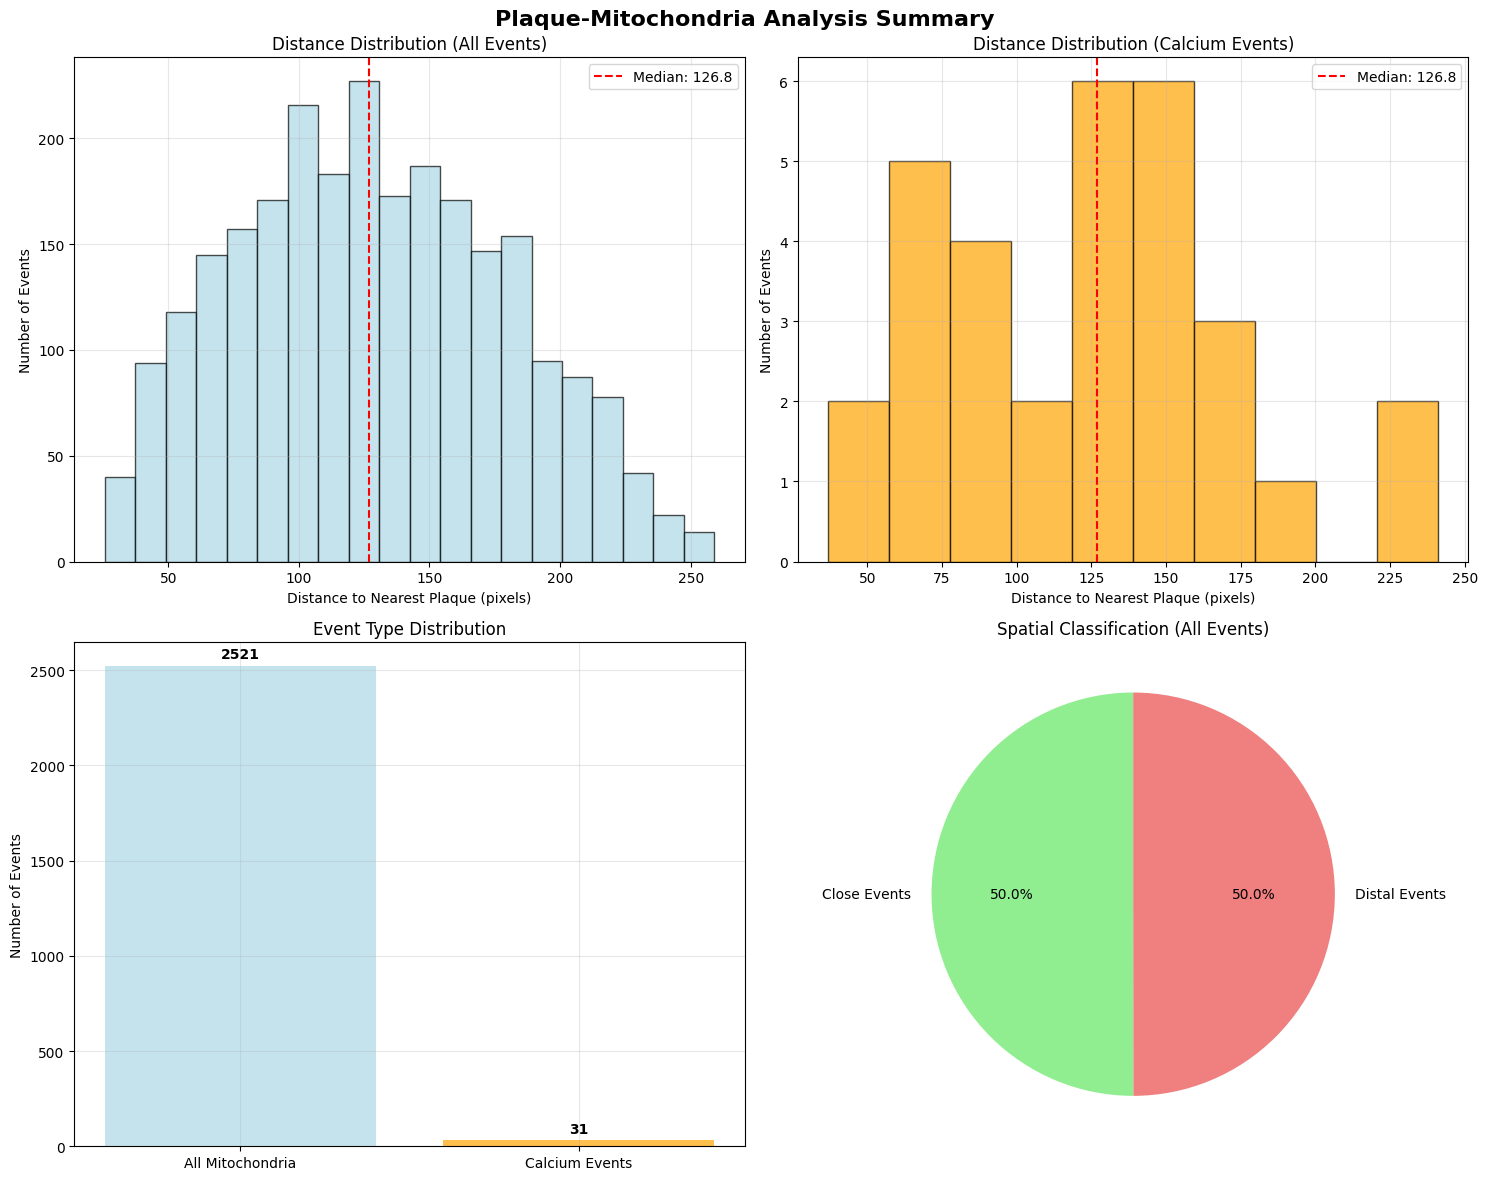


ANALYSIS SUMMARY
Total plaques identified: 7
Filtered plaques (volume ≥ 50): 2
Total mitochondrial events: 2521
Calcium events: 31

Distance Analysis:
  Median distance: 126.83 pixels
  Mean distance: 128.68 pixels
  Distance range: 25.76 - 259.07 pixels
  Close events: 1261 (50.0%)
  Distal events: 1260 (50.0%)

Calcium Events Analysis:
  Close calcium events: 14 (45.2%)
  Distal calcium events: 17 (54.8%)

Analysis completed successfully!


In [14]:
# Create summary visualizations
print("Creating summary visualizations...")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Plaque-Mitochondria Analysis Summary', fontsize=16, fontweight='bold')

# 1. Distance distribution histogram for all events
axes[0, 0].hist(all_distances, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].axvline(median_distance, color='red', linestyle='--', 
                   label=f'Median: {median_distance:.1f}')
axes[0, 0].set_xlabel('Distance to Nearest Plaque (pixels)')
axes[0, 0].set_ylabel('Number of Events')
axes[0, 0].set_title('Distance Distribution (All Events)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distance distribution histogram for calcium events
axes[0, 1].hist(calcium_distances, bins=10, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(median_distance, color='red', linestyle='--', 
                   label=f'Median: {median_distance:.1f}')
axes[0, 1].set_xlabel('Distance to Nearest Plaque (pixels)')
axes[0, 1].set_ylabel('Number of Events')
axes[0, 1].set_title('Distance Distribution (Calcium Events)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Event type distribution
event_types = ['All Mitochondria', 'Calcium Events']
event_counts = [len(mito_centroids), len(calcase_centroids)]
colors = ['lightblue', 'orange']

axes[1, 0].bar(event_types, event_counts, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Number of Events')
axes[1, 0].set_title('Event Type Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, count in enumerate(event_counts):
    axes[1, 0].text(i, count + max(event_counts) * 0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

# 4. Spatial classification pie chart
classification_labels = ['Close Events', 'Distal Events']
classification_counts = [len(close_events), len(distal_events)]
classification_colors = ['lightgreen', 'lightcoral']

axes[1, 1].pie(classification_counts, labels=classification_labels, colors=classification_colors, 
               autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Spatial Classification (All Events)')

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Total plaques identified: {len(all_blobs_info)}")
print(f"Filtered plaques (volume ≥ {volume_threshold}): {len(filtered_blobs_info)}")
print(f"Total mitochondrial events: {len(mito_centroids)}")
print(f"Calcium events: {len(calcase_centroids)}")

print(f"\nDistance Analysis:")
print(f"  Median distance: {median_distance:.2f} pixels")
print(f"  Mean distance: {np.mean(all_distances):.2f} pixels")
print(f"  Distance range: {min(all_distances):.2f} - {max(all_distances):.2f} pixels")
print(f"  Close events: {len(close_events)} ({len(close_events)/len(all_distances)*100:.1f}%)")
print(f"  Distal events: {len(distal_events)} ({len(distal_events)/len(all_distances)*100:.1f}%)")

print(f"\nCalcium Events Analysis:")
print(f"  Close calcium events: {len(close_calcium)} ({len(close_calcium)/len(calcium_distances)*100:.1f}%)")
print(f"  Distal calcium events: {len(distal_calcium)} ({len(distal_calcium)/len(calcium_distances)*100:.1f}%)")

print("\nAnalysis completed successfully!")